# Mailing List Analysis with BigBang

In [4]:
from __future__ import print_function
from bigbang.archive import Archive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re as re
import networkx as nx
import bigbang as bb
%matplotlib inline

In [3]:
class mArchive(object):
    def __init__(self, archives,names=False):
        self.archives = archives
        self.rname = re.compile("(.+) \((.+)\)")
        self.disambigue_from(archives)
        self.data = [self.index(i.data) for i in archives]
        if names == False:
            names = range(0,len(self.data))
        self.ml_names = names
        #self.activity =  self.compute_activity(self.data,self.dict_mails)

    def index(self,df):
        df["Invididual"] = df["From"].apply(lambda x: self.dict_from[x])
        return df
        
    def unique_id(self,df):
        names = []
        mails = []
        for i in list(self.data["From"].values):
            mail,name = rname.match(i.lower().replace("\n"," ")).groups()
            names.append(name)
            mails.append(mail)
        return set(names),set(mails)
    
    def extract_from(self,d):
        try:
            mail,name = self.rname.match(d.lower().replace("\n"," ")).groups()
        except:
            print(d)
            mail,name = "na","na"
        return mail,name

    def network_mail_name(self,relations):
        G = nx.Graph()
        for i in relations:
            mail,name = i
            if not mail in G.node:
                G.add_node(mail, status = "mail")
            if not name in G.node:
                G.add_node(name, status = "name")
            G.add_edge(mail,name)
        return G

    def dict_name_mail_cluster(self,G):
        dict_clusters = {}
        dict_individual = {}
        dict_mails = {}
        l = sorted(nx.connected_components(G), key = len, reverse=True)
        for i in range(0,len(l)):
            if len(l[i])>10:
                print("\nCareful, a component contain more than 10 entities. Maybe there is an homonym")
                print(l[i])
                print("n\n")
            for j in l[i]:
                dict_clusters[j] = i
            a = dict_individual[i] = sorted([u for u in l[i] if not "@" in u and not " at " in u], key = len, reverse=True)
            if len(a)==0:
                dict_individual[i] = l[i][0]
            else:
                dict_individual[i] = a[0]
        for i in [i for i in G.node if G.node[i]["status"]=='mail']:
            name = dict_individual[dict_clusters[i]].replace("=f6","o").replace("e9","e").replace("?iso-8859-1?q?","").replace("?=","").replace("=?windows-1252?q?","").replace("=","").replace("?windows-1250?q?","").replace("?iso-8859-15?q?","").replace("_"," ")
            dict_mails[i] = name.title()+" [id:"+str(dict_clusters[i])+"]"
        return dict_clusters,dict_individual, dict_mails

    def dict_from(self,from_set):
        from_cleaned =  {}
        for i in from_set:
            from_cleaned[i] = self.attribute_id(i,self.dict_mails)
        return from_cleaned

    def attribute_id(self,from_field,dict_id):
        mail,name = self.extract_from(from_field)
        try:
            return dict_id[mail]
        except:
            return "na"

    def compute_activity(self,mdf,dict_id):
        mdf["Id"] = mdf['From'].apply(lambda x: self.attribute_id(x,dict_id))
        mdf2 = mdf.reindex(columns = ['Id', 'Date'])
        mdf2['Date'] = mdf['Date'].apply(lambda x: x.toordinal())
        activity = mdf2.groupby(
            ['Id', 'Date']).size().unstack('Id').fillna(0)
        new_date_range = np.arange(mdf2['Date'].min(), mdf2['Date'].max())
        activity = activity.reindex(new_date_range, fill_value=0)
        return activity
    
    def display_list_individuals(self,n):
        ta = self.activity.sum(0) # sum along the first axis
        ta.sort()
        ta[-n:].plot(kind='barh', width=1)
        plt.show()
        print(ta[-n:])
        
    def weighted_individuals(self):
        ta = self.activity.sum(0) # sum along the first axis
        ta.sort()
        return ta
    
    def disambigue_from(self,mls):
        from_set = []
        for i in mls:
            from_set+=list(i.data["From"])
        id_set = [self.extract_from(i) for i in from_set]
        G = self.network_mail_name(id_set)
        self.dict_clusters,self.dict_individual,self.dict_mails = self.dict_name_mail_cluster(G)
        self.dict_from = self.dict_from(from_set)
        
    def network_between_mls(self,n):
        G = nx.Graph()
        #m = np.zeros((len(self.data),len(self.data)))
        #first_n = [(i["Invididual"]).value_counts()[0:n].keys() for i in self.data]
        #for i in range(0,len(self.data)):
        #    for j in range(i+1,len(self.data)):
        #        m[i,j] = len(set(first_n[i]).intersection(first_n[j]))
        #        m[j,i] = m[i,j]
        #return m
        for i in range(0, len(self.data)):
            t = int(sum(self.data[i]["Invididual"].value_counts()))
            G.add_node(str(self.ml_names[i]),Label=str(self.ml_names[i]),status="ML",weight=t)
            d = self.data[i]["Invididual"].value_counts()[0:n]
            for j in d.keys():
                if not j in G.node:
                    G.add_node(j,Label=j,Status="Individual",weight=int(d[j]))
                else:
                    G.node[j]["weight"]+=int(d[j])
                G.add_edge(j,self.ml_names[i],weight = int(d[j]/(0.1*t)))
        nx.write_graphml(G,"network_mls.graphml")
        return G
            

Load mailing-list (they should be downloaded with bigbang script)

In [2]:
ml_dev = Archive("ipython-dev",archive_dir="../bigbang/archives")
ml_user = Archive("ipython-user",archive_dir="../bigbang/archives")
ml_list = {"Ipython development ML":ml_dev,"Ipython user ML":ml_user}
t = mArchive([ml_dev,ml_user],["Ipython development ML","Ipython user ML"])

NameError: name 'mArchive' is not defined

# ML contributions

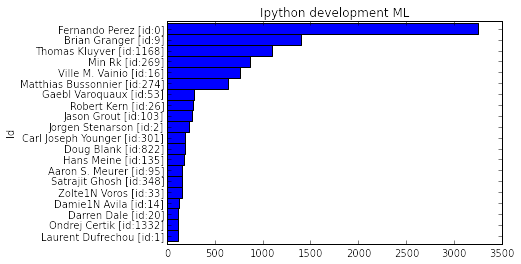

Id
Jorgen Stenarson [id:2]          235
Jason Grout [id:103]             260
Robert Kern [id:26]              274
Gaebl Varoquaux [id:53]          288
Matthias Bussonnier [id:274]     643
Ville M. Vainio [id:16]          762
Min Rk [id:269]                  869
Thomas Kluyver [id:1168]        1095
Brian Granger [id:9]            1402
Fernando Perez [id:0]           3254
dtype: float64


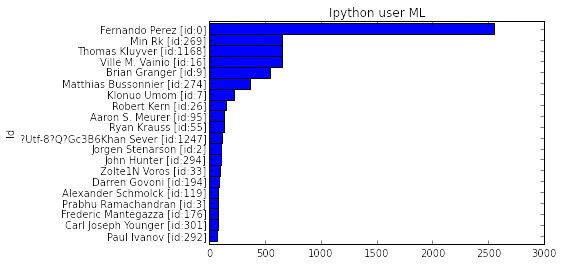

Id
Ryan Krauss [id:55]              131
Aaron S. Meurer [id:95]          132
Robert Kern [id:26]              152
Klonuo Umom [id:7]               221
Matthias Bussonnier [id:274]     365
Brian Granger [id:9]             542
Ville M. Vainio [id:16]          650
Thomas Kluyver [id:1168]         653
Min Rk [id:269]                  653
Fernando Perez [id:0]           2549
dtype: float64


In [37]:
for i in range(0,len(t.data)):
    a = t.compute_activity(t.data[i],t.dict_mails)
    ta = a.sum(0) # sum along the first axis
    ta.sort()
    ta[-20:].plot(kind='barh', width=1)
    plt.title(t.ml_names[i])
    plt.show()
    print(ta[-10:])

** When do they send their first mail ? **

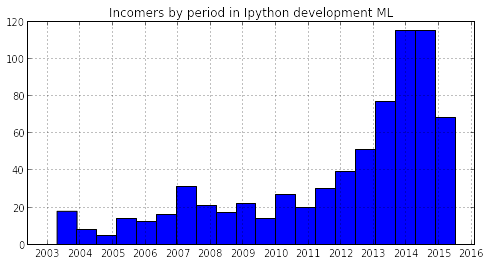

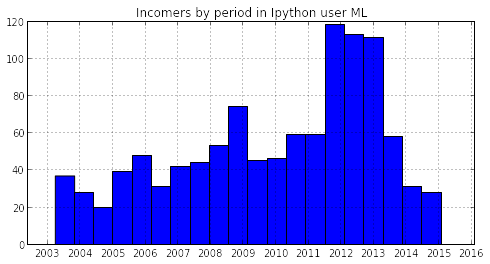

In [43]:
for i in range(0,len(t.data)):
    fig = plt.figure(figsize=(8, 4))
    a = t.compute_activity(t.data[i],t.dict_mails)
    (a > 0).idxmax().hist(bins=20)
    plt.title("Incomers by period in "+t.ml_names[i])
    fig.axes[0].xaxis_date()
    plt.show()

In [45]:
from bigbang import plot
n = 5

for ml_name in ml_list:
    ml = ml_list[ml_name]
    print("\n\n###{name}###\n".format(name=ml_name))
    dict_clusters,dict_individual,dict_mails = dict_name_mail_cluster(network_mail_name(ml.data))
    a = compute_activity(ml.data,dict_mails)    
    first_post = (a > 0).idxmax().order()
    cohorts = np.array_split(first_post,n)
    cohorts = [c.keys() for c in cohorts]
    print("Evolution from {a} cohorts".format(a=str(n)))
    plot.stack(a,partition=cohorts,smooth=100)



###Ipython user ML###



NameError: name 'dict_name_mail_cluster' is not defined

Evolution from 5 cohorts


AttributeError: 'AxesSubplot' object has no attribute 'stackplot'

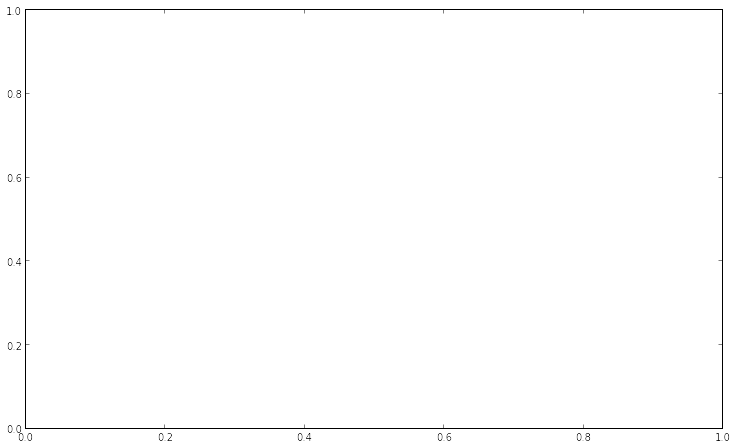

In [46]:
a = ml_dev.compute_activity()
first_post = (a > 0).idxmax().order()
cohorts = np.array_split(first_post,n)
cohorts = [c.keys() for c in cohorts]
print("Evolution from {a} cohorts".format(a=str(n)))
plot.stack(a,partition=cohorts,smooth=100)

## Threads



###Ipython user ML###



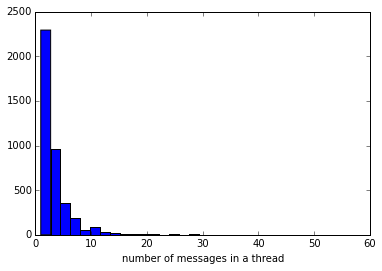



###Ipython development ML###



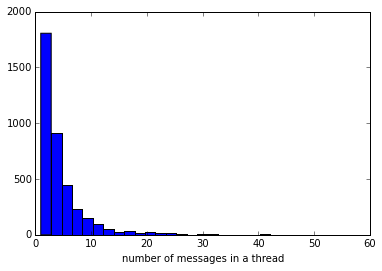

In [237]:
for ml_name in ml_list:
    ml = ml_list[ml_name]
    print("\n\n###{name}###\n".format(name=ml_name))
    ml.get_threads()
    y = [t.get_num_messages() for t in ml.get_threads()]
    plt.hist(y, bins=30)
    plt.xlabel('number of messages in a thread')
    plt.show()

**Who starts threads ?**



###Ipython user ML###


Careful, a component contain more than 10 entities. Maybe there is an homonym
['fernando.perez@colorado.edu', 'fperez@colorado.edu', 'fperez.net at gmail.com', 'ipython at gmail.com', 'fernando.perez-1 at colorado.edu', 'fernando.perez@colorado....', 'fernando perez', 'fernando.perez@berkeley....', 'fperez at colorado.edu', 'fperez.net@gmail....', 'fernando.perez at colorado.edu']
n



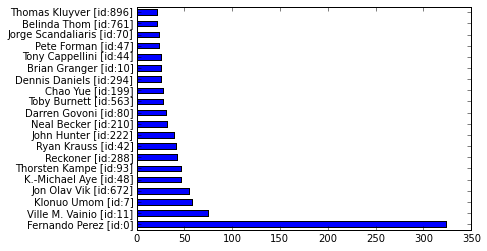



###Ipython development ML###



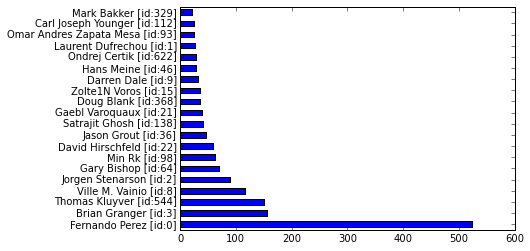

In [240]:
for ml_name in ml_list:
    ml = ml_list[ml_name]
    print("\n\n###{name}###\n".format(name=ml_name))
    dict_clusters,dict_individual,dict_mails = dict_name_mail_cluster(network_mail_name(ml.data))
    senders = pd.Series([attribute_id(i.get_root().data["From"],dict_mails) for i in ml.get_threads() if i.known_root])
    senders.value_counts()[0:20].plot(kind='barh')
    plt.show()

**Who answers threads ?**



###Ipython user ML###


Careful, a component contain more than 10 entities. Maybe there is an homonym
['fernando.perez@colorado.edu', 'fperez@colorado.edu', 'fperez.net at gmail.com', 'ipython at gmail.com', 'fernando.perez-1 at colorado.edu', 'fernando.perez@colorado....', 'fernando perez', 'fernando.perez@berkeley....', 'fperez at colorado.edu', 'fperez.net@gmail....', 'fernando.perez at colorado.edu']
n



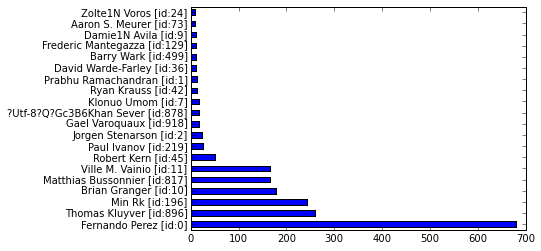



###Ipython development ML###



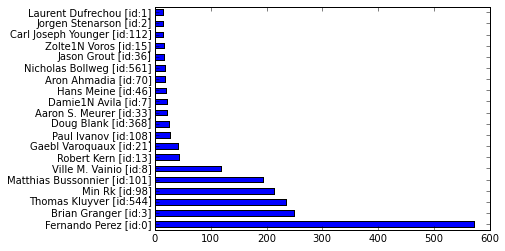

In [241]:
for ml_name in ml_list:
    ml = ml_list[ml_name]
    print("\n\n###{name}###\n".format(name=ml_name))
    dict_clusters,dict_individual,dict_mails = dict_name_mail_cluster(network_mail_name(ml.data))
    respondents = pd.Series([attribute_id(i.get_root().get_successors()[0].data["From"],dict_mails) for i in ml.get_threads() if i.known_root and i.get_num_messages()>1])
    respondents.value_counts()[0:20].plot(kind='barh')
    plt.show()

In [248]:
with open("content-mail-python.txt","w") as f:
    for ml_name in ml_list:
        ml = ml_list[ml_name]
        ml_name=ml_name.replace(" ","")
        for i in ml.data["Body"]:
            try:
                f.write("\n**** *list_{list}\n{content}\n".format(list=ml_name,content=i.replace("*"," ")))
            except:
                print(i)

None
None
None
None
None
None
None
None
